In [1]:
import glob
import os
import pandas as pd
import numpy as np

def read_proxy_test(directory, max_simul):
    means, low, high = [], [], []
    for i in range(1, max_simul+1):
        f = os.path.join(directory, 'simul_%d.txt'%i)
        df = pd.read_csv(f, names=('client', 'i', 'time'))
        means.append(np.percentile(df.time, 50))
        low.append(np.percentile(df.time, 1))
        high.append(np.percentile(df.time, 99))
    return np.array(means)*1e3, np.array(low)*1e3, np.array(high)*1e3
        
# y, err = read_proxy_test("proxy_tests/tsproxy", 50)
sl2 = read_proxy_test("proxy_tests/eb_tsproxy", 200)



In [2]:
noproxy = read_proxy_test('proxy_tests/noproxy', 200)

In [390]:
sl1 = read_proxy_test('proxy_tests/slproxy_1', 200)

In [391]:
ha1_mc = read_proxy_test('proxy_tests/haproxy_1_mc', 200)

In [392]:
ha1 = read_proxy_test('proxy_tests/haproxy_1a', 200)

In [393]:
ha2 = read_proxy_test("proxy_tests/haproxy_2a", 200)

In [394]:
ha2_mc = read_proxy_test("proxy_tests/haproxy_2_mc", 200)

In [395]:
sl2 = read_proxy_test("proxy_tests/slproxy_2", 200)

In [396]:
ha3 = read_proxy_test('proxy_tests/haproxy_3a', 200)

In [397]:
ha3_mc = read_proxy_test('proxy_tests/haproxy_3_mc', 200)

In [398]:
sl3 = read_proxy_test('proxy_tests/slproxy_3', 200)

In [399]:
ha4 = read_proxy_test('proxy_tests/haproxy_4', 200)

In [400]:
ha4_mc = read_proxy_test('proxy_tests/haproxy_4_mc', 200)

In [401]:
sl4 = read_proxy_test('proxy_tests/slproxy_4', 200)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib notebook
sns.set_style('whitegrid')

NameError: name 'ha1' is not defined

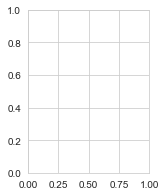

In [3]:
def make_proxy_latency_plot(series, labels = ['HaProxy', 'Socket Launcher'], baseline=None, ):
    handles = []
    for serie in series:
        m, l, h = serie
        if baseline is not None:
            m = m - baseline[:len(m)]
            l = l - baseline[:len(m)]
            h = h - baseline[:len(m)]
        x = range(1, len(m) + 1)
        plt.plot(x, m)
        handles.append(plt.fill_between(x, l, h, alpha=.2))

    plt.xlabel("# Simultaneous Clients")
    if baseline is None:
        plt.ylabel("Echo Latency (ms)")
    else:
        plt.ylabel("Latency over baseline (ms)")

    plt.legend(labels=labels, handles=handles)

plt.figure(figsize=(10,3))
ax = plt.subplot(141)
make_proxy_latency_plot([ha1, ha1_mc, sl1], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher', 'No Proxy'],)
#                         noproxy[0])
plt.title("1 Server")
plt.subplot(142, sharey=ax)
make_proxy_latency_plot([ha2, ha2_mc, sl2], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/2)
plt.title("2 Servers")
plt.subplot(143, sharey=ax)
make_proxy_latency_plot([ha3, ha3_mc, sl3], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/3)
plt.title("3 Servers")
plt.subplot(144, sharey=ax)
make_proxy_latency_plot([ha4, ha4_mc, sl4], ['HaProxy', 'Haproxy 4-core', 'Socket Launcher'],)
#                        noproxy[0]/4)
plt.title("4 Servers")

plt.tight_layout()

In [4]:
import json
def read_iperf_proxy_test(directory, max_simul):
    means, low, high = [], [], []
    for i in range(2, max_simul+1):
        f = os.path.join(directory, 'simul_%d.txt'%i)
        results = json.load(open(f))
        bps = []
        for interval in results['intervals'][10:]:
            bps.append(interval['sum']['bits_per_second'])
        means.append(sum(bps) / len(bps))
        low.append(min(bps))
        high.append(max(bps))
    return np.array(means) * 1e-9, np.array(low) * 1e-9, np.array(high)*1e-9

iperf_ha = read_iperf_proxy_test('proxy_tests/iperf_haproxy_3/', 100)
iperf_ha_mc = read_iperf_proxy_test('proxy_tests/iperf_haproxy_mc', 100)
iperf_ts = read_iperf_proxy_test('proxy_tests/iperf_slproxy_short', 100)
iperf_no = read_iperf_proxy_test('proxy_tests/iperf_noproxy', 100)

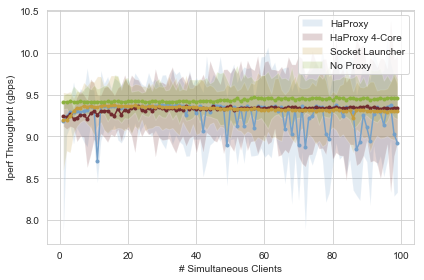

In [5]:
def make_proxy_plot(series, labels, dec10=False):
    handles = []
    for serie in series:
        y1, l1, h1 = serie
        if dec10:
            y1 = (10-y1)
            l1 = (10-l1)
            h1 = (10-h1)
        x = range(1, len(y1)+1)
        plt.plot(x, y1, '.-')
        handles.append(plt.fill_between(x, l1, h1, alpha=.2))

    plt.xlabel("# Simultaneous Clients")
    if not dec10:
        plt.ylabel("Iperf Throughput (gbps)")
    else:
        plt.ylabel("Iperf Throughput Loss (gbps)")
            
    # plt.yscale('log')

    plt.legend(labels=labels, handles=handles)
    
plt.figure()
make_proxy_plot([iperf_ha, iperf_ha_mc, iperf_ts, iperf_no], ['HaProxy', 'HaProxy 4-Core', 'Socket Launcher', 'No Proxy'])
plt.tight_layout()

In [6]:
import pandas as pd
import numpy as np
import os
import pickle

def read_xfer_test(test_file, xfer_interval, has_time=False):
    picklef = os.path.splitext(test_file)[0] + '.pickle'
    if os.path.exists(picklef):
        with open(picklef, 'rb') as f:
            return pickle.load(f)
    xmeans, xlow, xhigh = [], [], []
    nmeans, nlow, nhigh = [], [], []
    f = open(test_file)
    if not has_time:
        df = pd.read_csv(f, names=('client', 'i', 'time'))
    else:
        df = pd.read_csv(f, names=('start', 'client', 'i', 'time'))
    
    df.time *= 1e3
    
    df['idx'] = df.i % xfer_interval
    return df


In [7]:
def plot_xfer_hist(df, idx, color='g'):
    plt.hist(df[df.idx == idx].time,
             bins = np.arange(0, np.percentile(df.time, 99), 0.02),
             label='Xfer',
             color='b',
             density=True)
    plt.hist(df[df.idx != idx].time, 
             bins = np.arange(0, np.percentile(df.time, 99), 0.02),
             label='Non-Xfer',
             color=color,
             density=True)
    
    plt.xlabel("Latency (ms)")
    plt.ylabel("Probability Density")


<IPython.core.display.Javascript object>


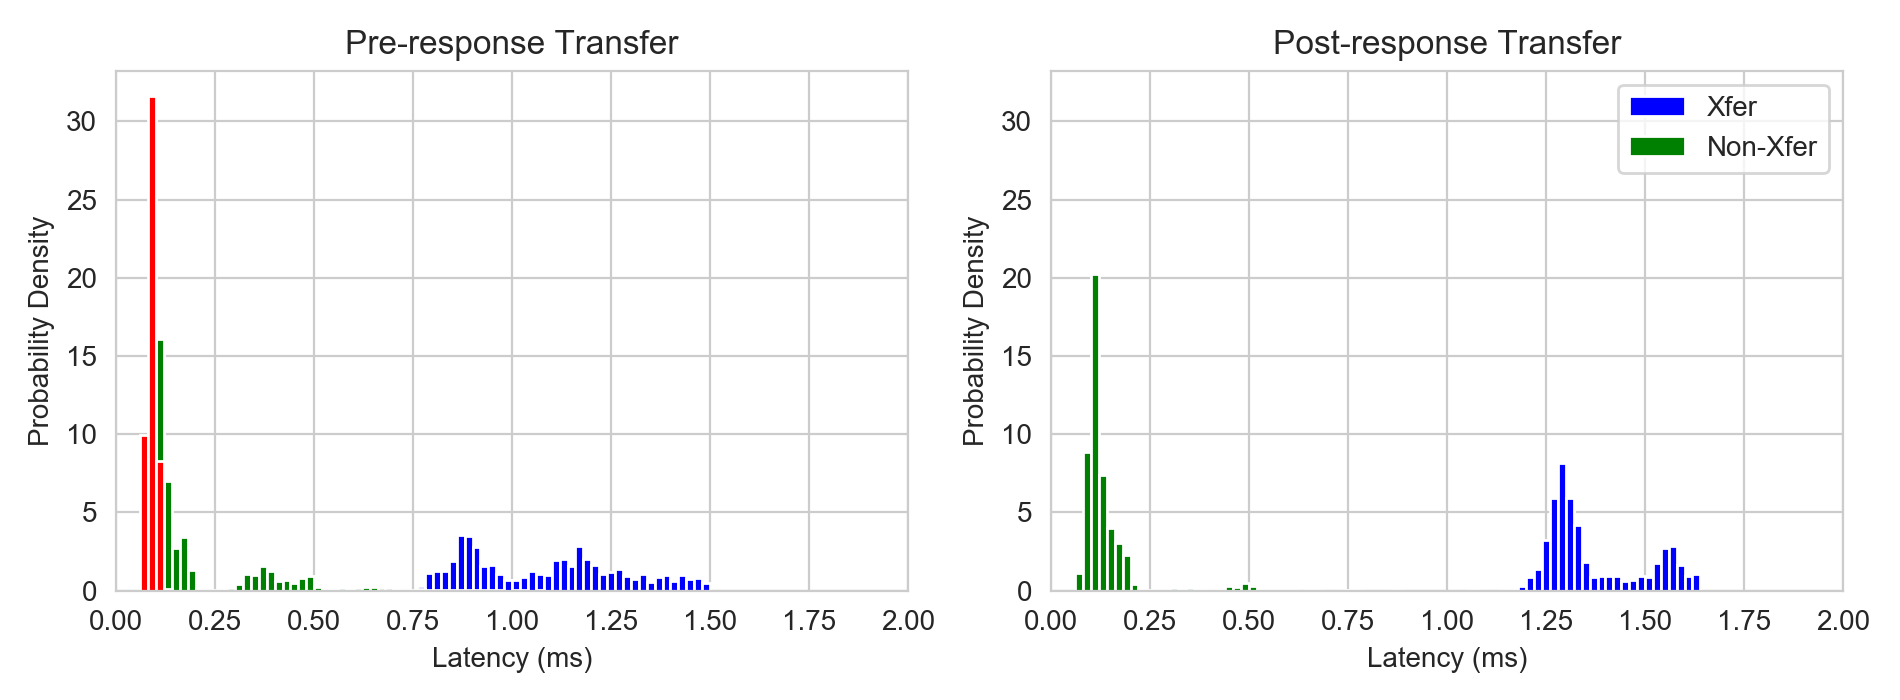

In [568]:
import seaborn as sns
sns.set_style('whitegrid')

df_nosimul = read_xfer_test('pre_transfer/noxfer_simul_1.csv', 10)
df_pre = read_xfer_test('pre_transfer_no_nodelay_10/simul_1.csv', 10)
df_post = read_xfer_test('post_transfer_10.csv', 10)
plt.figure(figsize=(9.5,3.5))
ax = plt.subplot(121)
plot_xfer_hist(df_pre, 9)
plot_xfer_hist(df_nosimul, -1, 'r')
plt.title("Pre-response Transfer")
plt.subplot(122, sharex=ax, sharey=ax)
plot_xfer_hist(df_post, 0)
plt.title("Post-response Transfer")
plt.xlim(0, 2)
plt.legend()
plt.tight_layout()


In [517]:
df_simul_1 = read_xfer_test('pre_transfer_2/simul_1.csv', 10)
df_simul_2 = read_xfer_test('pre_transfer_2/simul_2.csv', 10)

<IPython.core.display.Javascript object>


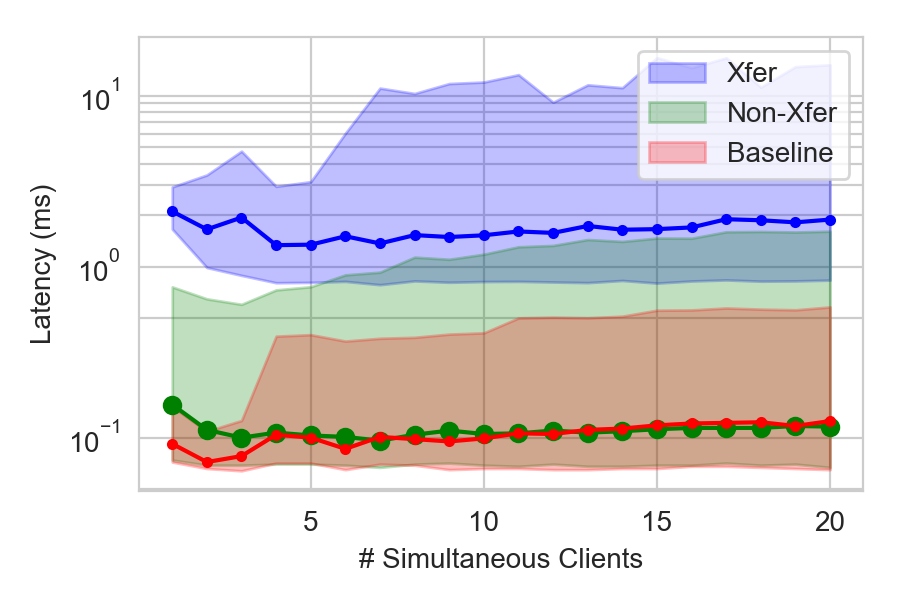

In [562]:
plt.figure(figsize=(4.5, 3))

x = np.arange(1, 21)
y1 = []
l1 = []
h1 = []

y2 = []
l2 = []
h2 = []

y3 = []
l3 = []
h3 = []

n = 100
for i in range(1,21):
    df_simul = read_xfer_test('pre_transfer_no_nodelay_100/simul_%d.csv' % i, n)
    df_x = df_simul[df_simul.idx == n-1]
    df_nx = df_simul[df_simul.idx != n-1]
    y1.append(df_x.time.median())
    l1.append(np.percentile(df_x.time, 1))
    h1.append(np.percentile(df_x.time, 99))
    y2.append(df_nx.time.median())
    l2.append(np.percentile(df_nx.time, 1))
    h2.append(np.percentile(df_nx.time, 99))

    df_nosimul = read_xfer_test('pre_transfer/noxfer_simul_%d.csv' % i, 10)
    y3.append(df_nosimul.time.median())
    l3.append(np.percentile(df_nosimul.time, 1))
    h3.append(np.percentile(df_nosimul.time, 99))
    
    
plt.fill_between(x, l1, h1, color='b', alpha=.25, label='Xfer')
plt.fill_between(x, l2, h2, color='green', alpha=.25, label='Non-Xfer')
plt.fill_between(x, l3, h3, color='red', alpha=.25, label='Baseline')
plt.plot(x, y1, '.-', color='b')
plt.plot(x, y2, 'o-', color='green')
plt.plot(x, y3, '.-', color='red')
plt.xlabel("# Simultaneous Clients")
plt.ylabel("Latency (ms)")
plt.yscale('log')
plt.yticks([.05, .1, .5, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
plt.legend()
plt.tight_layout()
    

<IPython.core.display.Javascript object>


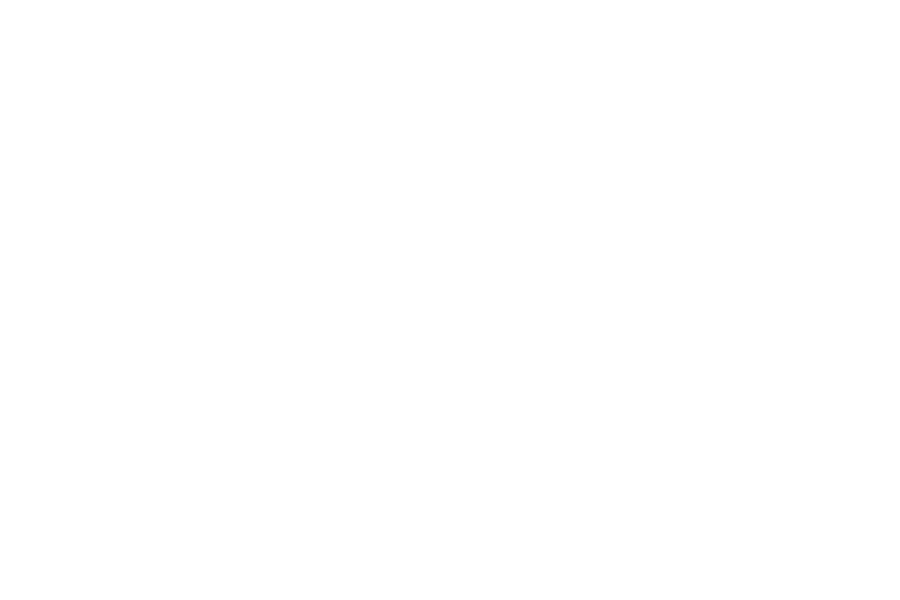

1
2
3
4
5
6
7
8
9
10
11
12


IndexError: cannot do a non-empty take from an empty axes.

In [569]:
plt.figure(figsize=(4.5, 3))
x = np.arange(0, 20)
y1 = []
l1 = []
h1 = []


y3 = []
l3 = []
h3 = []
for i in range(1, 21):
    print(i)
    df_simul = read_xfer_test('bg/bg_xfer_simul_%d.csv' % i, 10)
    df_x = df_simul[df_simul.client == 0]
    y1.append(df_x.time.median())
    l1.append(np.percentile(df_x.time, 1))
    h1.append(np.percentile(df_x.time, 99))
    
    df_nosimul = read_xfer_test('pre_transfer/noxfer_simul_%d.csv' % i, 10)
    y3.append(df_nosimul.time.median())
    l3.append(np.percentile(df_nosimul.time, 1))
    h3.append(np.percentile(df_nosimul.time, 99))
    
plt.fill_between(x, l1, h1, color='b', alpha=.25, label='Non-Xfer Client')
plt.fill_between(x, l3, h3, color='r', alpha=.25, label='Baseline')

plt.plot(x, y3, 'o-', color='r')
plt.plot(x, y1, '.-', color='b')
plt.xlabel("# Transferring Clients")
plt.ylabel("Latency (ms)")
plt.legend()
plt.yscale("log")
plt.tight_layout()

In [378]:
df_q = read_xfer_test('queuing/q_tspeer3.csv', 1)
df_noq = read_xfer_test('queuing/noq_tspeer3.csv', 1)

In [379]:
df_q.shape

(1309932, 4)

In [380]:
df_noq.shape

(2395696, 4)

In [381]:
sum(df_q.time)

8826961.929999623

In [382]:
sum(df_noq.time)

8987734.328001475

In [383]:
np.percentile(df_noq.time, 98)

9.544

<IPython.core.display.Javascript object>


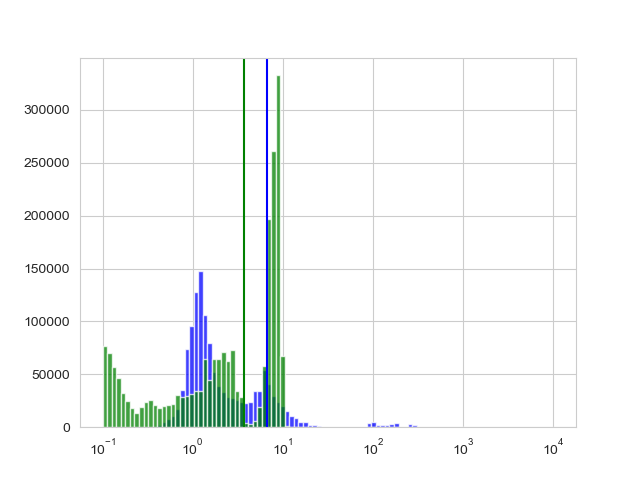

In [424]:
df_q = read_xfer_test('queuing/tq_tspeer3.csv', 1)
df_noq = read_xfer_test('queuing/noq_tspeer3.csv', 1)
df_q = df_q[df_q.client != 0]
df_noq = df_noq[df_noq.client != 0]
plt.figure()

qbins = np.logspace(-1, 4, 100)
plt.hist(df_q.time,
         bins = qbins,
         label='Xfer',
         color='b', alpha=.75)
plt.axvline(df_q.time.mean(), color='blue')
plt.hist(df_noq.time,
         bins = qbins,
         label='Xfer',
         color='g', alpha=.75)
plt.axvline(df_noq.time.mean(), color='green')
plt.xscale('log')


<IPython.core.display.Javascript object>


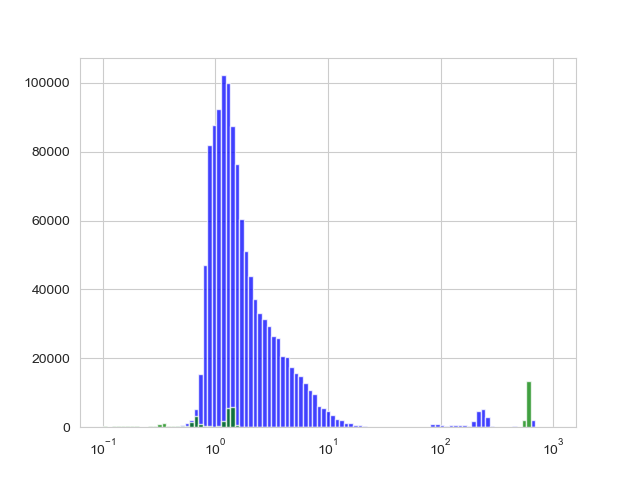

In [434]:
df_q = read_xfer_test('queuing/q_tspeer2.csv', 1)
df_noq = read_xfer_test('queuing/noq_tspeer.csv', 1)
df_q = df_q[df_q.client != 0]
df_noq = df_noq[df_noq.client != 0]
plt.figure()

qbins = np.logspace(-1, 3, 100)
plt.hist(df_q.time,
         bins = qbins,
         label='Xfer',
         color='b', alpha=.75)
plt.hist(df_noq.time,
         bins = qbins,
         label='Xfer',
         color='g', alpha=.75)
plt.xscale('log')


In [8]:
df_q = read_xfer_test('queuing/3_malicious_timed_q_tspeer_35.csv', 1, True)
df_noq = read_xfer_test('queuing/3_malicious_timed_noq_tspeer_35.csv', 1, True)

In [ ]:
df_q = read_xfer_test('thread_mal_ratio/nT%d_nM%d_{}/client.log')

In [9]:
def add_intervals(df):
    rounded_time = np.around(df.start, 1)
    interval = (rounded_time - min(rounded_time)) * 10
    df['interval'] = interval
    return df

/Users/iped/miniconda2/lib/python2.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


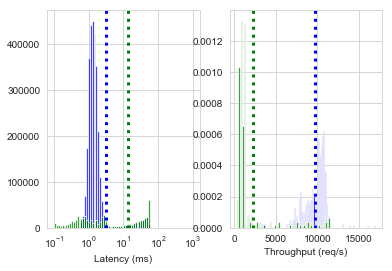

In [12]:
def compare_q_nq(df_q, df_noq, ax1=None, ax2=None):
    df_q = df_q[df_q.client != 0]
    df_noq = df_noq[df_noq.client != 0]
    add_intervals(df_q)
    add_intervals(df_noq)
    df_q_thru = df_q.groupby('interval').count().start
    df_noq_thru = df_noq.groupby('interval').count().start

    plt.subplot(121)
    qbins = np.logspace(-1, 3, 75)
    plt.hist(df_q.time,
             bins = qbins,
             label='Xfer',
             color='b', alpha=.75)
    plt.axvline(df_q.time.mean(), color='b', linewidth=3, linestyle=':')
    plt.hist(df_noq.time,
             bins = qbins,
             label='Xfer',
             color='g', alpha=.75)
    plt.xscale("log")
    plt.xlabel("Latency (ms)")
    plt.axvline(df_noq.time.mean(), color='g', linewidth=3, linestyle=':')
    # plt.yscale('log')

    plt.subplot(122)
    plt.hist(df_q_thru, 100, alpha=.75, color='b', normed=True)
    plt.hist(df_noq_thru, 100, alpha=.75, color='g', normed=True)
    plt.axvline(np.mean(df_q_thru), color='b', linewidth=3, linestyle=':')
    plt.axvline(np.mean(df_noq_thru), color='g', linewidth=3, linestyle=':')
    plt.xlabel("Throughput (req/s)")

plt.figure()
compare_q_nq(df_q, df_noq)

In [64]:
%matplotlib notebook

qs_lat = []
nqs_lat = []
qs_thr = []
nqs_thr = []
for threads in range(1, 5):
    print(threads)
    this_q_thr = []
    this_nq_thr = []
    this_q_lat = []
    this_nq_lat = []
    for mal in range(1, threads*3 + 1):
        base = 'thread_mal_ratio/nT4_nM12_{}/client.log' % (threads, mal)
        q = read_xfer_test(base.format('q'), 1, True)
        nq = read_xfer_test(base.format('noq'), 1, True)
#         plt.figure(figsize=(6, 4))
#         compare_q_nq(q, nq)
#         plt.title("Threads: %d, Mal: %d" % (threads, mal))
        add_intervals(q)
        add_intervals(nq)
        df_q_thru = q.groupby('interval').count().start
        df_noq_thru = nq.groupby('interval').count().start
        
        this_q_thr.append(df_q_thru.mean())
        this_nq_thr.append(df_noq_thru.mean())
        
        this_q_lat.append(q.time.mean())
        this_nq_lat.append(nq.time.mean())
        
    qs_lat.append(this_q_lat)
    nqs_lat.append(this_nq_lat)
    
    qs_thr.append(this_q_thr)
    nqs_thr.append(this_nq_thr)


1
2
3
4


<IPython.core.display.Javascript object>


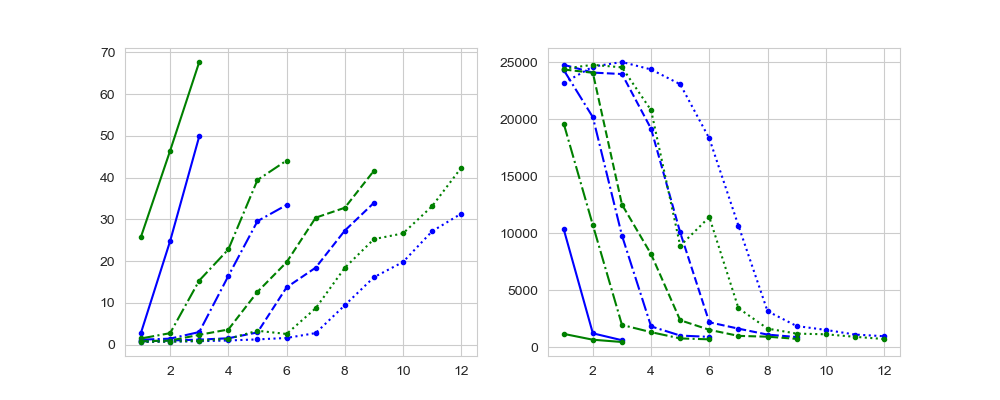

<IPython.core.display.Javascript object>


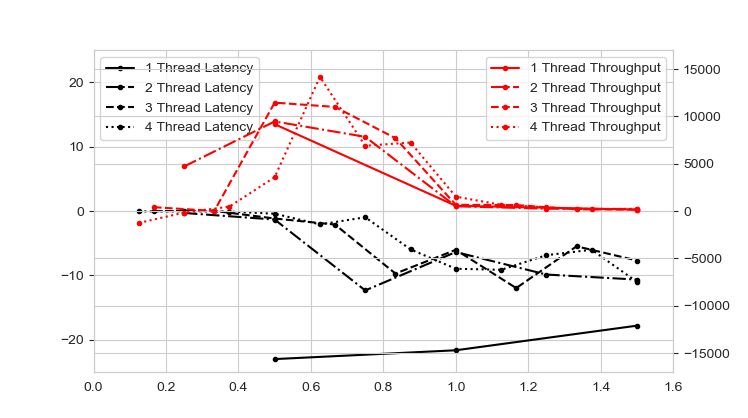

(0, 1.6)

In [75]:
plt.figure(figsize=(10,4))

ratio = False
plt.subplot(121)
styles = '-', '-.', '--', ':'
for i, (qlat, nqlat) in enumerate(zip(qs_lat, nqs_lat)):
    if ratio:
        x = np.arange(1, len(qlat) + 1) / float(len(qlat)) * 3.0
    else:
        x = np.arange(1, len(qlat)+1)
    
    plt.plot(x, qlat, color='b', linestyle=styles[i], marker='.')
    plt.plot(x, nqlat, color='g', linestyle=styles[i], marker='.')
    
plt.subplot(122)
for i, (qlat, nqlat) in enumerate(zip(qs_thr, nqs_thr)):
    if ratio:
        x = np.arange(1, len(qlat) + 1) / float(len(qlat)) * 1.5
    else:
        x = np.arange(1, len(qlat)+1)
        
    plt.plot(x, qlat, color='b', linestyle=styles[i], marker='.')
    plt.plot(x, nqlat, color='g', linestyle=styles[i], marker='.')
    
ratio = True
plt.figure(figsize=(6,4))
ax = plt.subplot()
ax2 = ax.twinx()
styles = '-', '-.', '--', ':'
for i, (qlat, nqlat, qthr, nqthr) in enumerate(zip(qs_lat, nqs_lat, qs_thr, nqs_thr)):
    if ratio:
        x = np.arange(1, len(qlat) + 1) / float(len(qlat)) * 1.5
    else:
        x = np.arange(1, len(qlat)+1)
    
    plt.sca(ax)
    plt.plot(x, np.array(qlat) - np.array(nqlat), color='k', linestyle=styles[i], marker='.', label='%d Thread Latency'% (i+1))
    plt.sca(ax2)
    plt.plot(x, np.array(qthr) - np.array(nqthr), color='r', linestyle=styles[i], marker='.', label='%d Thread Throughput'% (i+1))
    
ax.set_ylim([-25, 25])

ax2.set_ylim([-17000, 17000])
ax.legend(loc='upper left')
ax2.legend(loc='upper right')
ax.set_xlim([0, 1.6])

In [515]:
add_intervals(df_q)
add_intervals(df_noq)
df_q_thru = df_q.groupby('interval').count().start
df_noq_thru = df_noq.groupby('interval').count().start

<IPython.core.display.Javascript object>


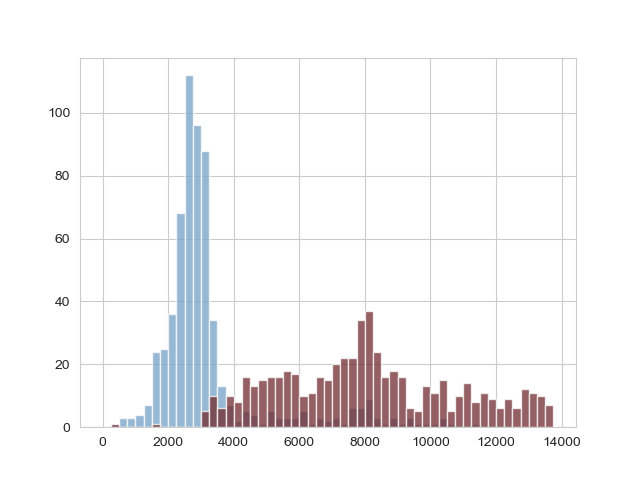

(array([ 0.,  1.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  5.,
        10.,  6., 10.,  8., 16., 13., 15., 16., 16., 18., 17., 10., 11.,
        16., 15., 20., 22., 22., 34., 37., 24., 16., 18., 16.,  6.,  5.,
        13., 11., 15.,  5., 10., 14.,  8., 11.,  9.,  6.,  9.,  6., 12.,
        11., 10.,  7.]),
 array([    0,   250,   500,   750,  1000,  1250,  1500,  1750,  2000,
         2250,  2500,  2750,  3000,  3250,  3500,  3750,  4000,  4250,
         4500,  4750,  5000,  5250,  5500,  5750,  6000,  6250,  6500,
         6750,  7000,  7250,  7500,  7750,  8000,  8250,  8500,  8750,
         9000,  9250,  9500,  9750, 10000, 10250, 10500, 10750, 11000,
        11250, 11500, 11750, 12000, 12250, 12500, 12750, 13000, 13250,
        13500, 13750]),
 <a list of 55 Patch objects>)

In [495]:
plt.figure()
plt.hist(df_q_thru, np.arange(0, 14000, 250), alpha=.75)
plt.hist(df_noq_thru, np.arange(0, 14000, 250), alpha=.75)

<IPython.core.display.Javascript object>


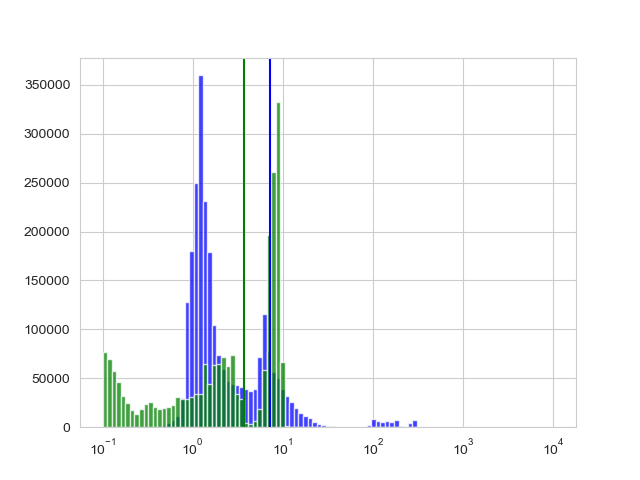

In [432]:

df_noq = read_xfer_test('queuing/noq_tspeer3.csv', 1)
df_q = df_q[df_q.client != 0]
df_noq = df_noq[df_noq.client != 0]
plt.figure()

qbins = np.logspace(-1, 4, 100)
plt.hist(df_q.time,
         bins = qbins,
         label='Xfer',
         color='b', alpha=.75)
plt.axvline(df_q.time.mean(), color='blue')
plt.hist(df_noq.time,
         bins = qbins,
         label='Xfer',
         color='g', alpha=.75)
plt.axvline(df_noq.time.mean(), color='green')
plt.xscale('log')
